# Toyota GR Cup: Tire Degradation Model Training

**Objective**: Predict tire degradation rate based on driving aggression metrics

**Dataset**: 
- 2,545 laps from Toyota GR Cup racing series
- 21 normalized features (brake pressure, G-forces, steering, throttle, speed, RPM)
- Target: `tire_degradation_rate` (seconds per lap)

**Models to Compare**:
1. Linear Regression (baseline)
2. Ridge Regression (L2 regularization)
3. Lasso Regression (L1 regularization)
4. Random Forest
5. Gradient Boosting
6. XGBoost (GPU-ready)

**Evaluation Metrics**: R², MAE, RMSE, Explained Variance

## ⚠️ Important Notes

**Data Quality:**
- **3 features removed**: `avg_throttle_pos`, `max_throttle_pos`, `throttle_variance` (all NULL)
- **Reason**: Dataset contains races with different throttle sensors:
  - Races 1-8: Use `ath` (throttle blade position) - **in current dataset**
  - Races 9-10: Use `aps` (accelerator pedal position) - not in current dataset
- **Solution**: Using only `avg_throttle_blade` which is available for all laps

**GPU Configuration (XGBoost 3.x):**
- Use `device='cuda'` instead of `tree_method='gpu_hist'`
- XGBoost will automatically fall back to CPU if GPU unavailable
- Current setup: NVIDIA RTX 3080 with CUDA 12.8

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from pathlib import Path
from datetime import datetime

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import xgboost as xgb

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print(f"XGBoost version: {xgb.__version__}")
print(f"XGBoost GPU support: {xgb.build_info()['USE_CUDA']}")

XGBoost version: 3.1.1
XGBoost GPU support: True


## 2. Load Preprocessed Data

In [2]:
# Load features and target
features_path = Path('../ml_data/features_normalized.csv')
target_path = Path('../ml_data/target_degradation.csv')

X = pd.read_csv(features_path)
y = pd.read_csv(target_path)['tire_degradation_rate']

# Drop columns with all NaN values
nan_features = X.columns[X.isnull().all()].tolist()
if nan_features:
    print(f"⚠️  Removing {len(nan_features)} features with all NaN values: {nan_features}")
    X = X.drop(columns=nan_features)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"No NaN values remaining: {X.isnull().sum().sum() == 0}")

⚠️  Removing 3 features with all NaN values: ['avg_throttle_pos', 'max_throttle_pos', 'throttle_variance']
Features shape: (2545, 18)
Target shape: (2545,)
No NaN values remaining: True


In [3]:
# Data Quality Check: Remove features with all NaN values
# Note: avg_throttle_pos, max_throttle_pos, throttle_variance are NaN because
# the dataset contains races with different throttle sensors (aps vs ath)
nan_features = X.columns[X.isnull().all()].tolist()

if nan_features:
    print(f"⚠️  Removing {len(nan_features)} features with all NaN values:")
    for feat in nan_features:
        print(f"   - {feat}")
    X = X.drop(columns=nan_features)
    print(f"\nFeatures after cleaning: {X.shape[1]}")
    print(f"Remaining features: {list(X.columns)}")
else:
    print("✅ No features with all NaN values found")

# Verify no NaN values remain
if X.isnull().sum().sum() > 0:
    print(f"\n⚠️  Warning: {X.isnull().sum().sum()} NaN values still present")
    print(X.isnull().sum()[X.isnull().sum() > 0])
else:
    print(f"\n✅ Dataset is clean: {X.shape[0]} samples × {X.shape[1]} features")

✅ No features with all NaN values found

✅ Dataset is clean: 2545 samples × 18 features


## 3. Exploratory Data Analysis (EDA)

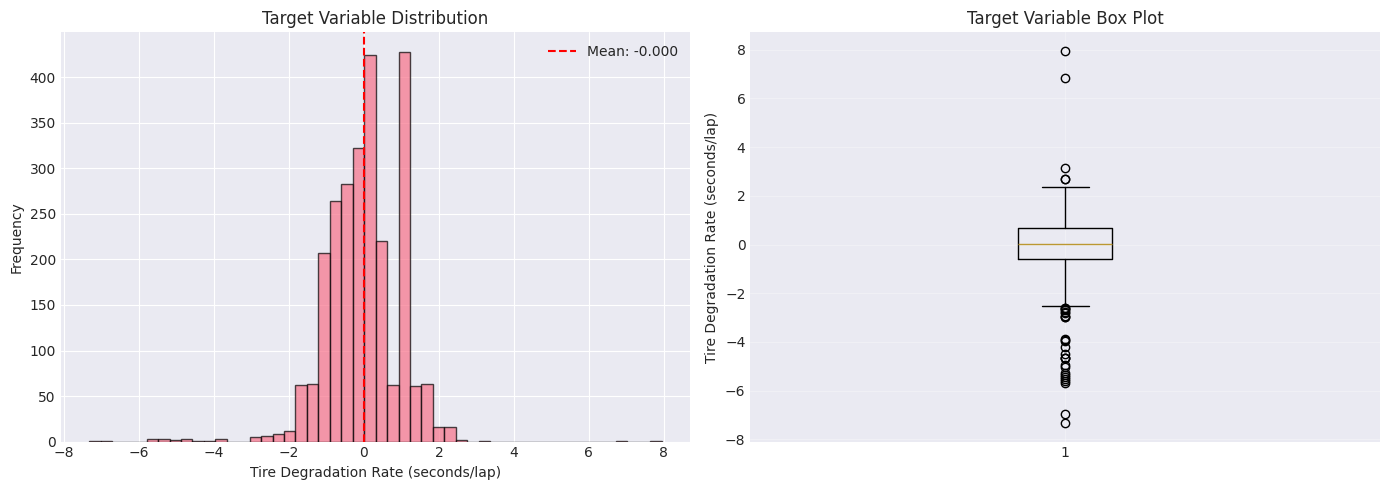

Target variable range: [-7.326, 7.948]
Outliers (> Q3 + 1.5*IQR): 5


In [4]:
# Target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(y, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Tire Degradation Rate (seconds/lap)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Target Variable Distribution')
axes[0].axvline(y.mean(), color='red', linestyle='--', label=f'Mean: {y.mean():.3f}')
axes[0].legend()

# Box plot
axes[1].boxplot(y, vert=True)
axes[1].set_ylabel('Tire Degradation Rate (seconds/lap)')
axes[1].set_title('Target Variable Box Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Target variable range: [{y.min():.3f}, {y.max():.3f}]")
print(f"Outliers (> Q3 + 1.5*IQR): {sum(y > y.quantile(0.75) + 1.5 * (y.quantile(0.75) - y.quantile(0.25)))}")

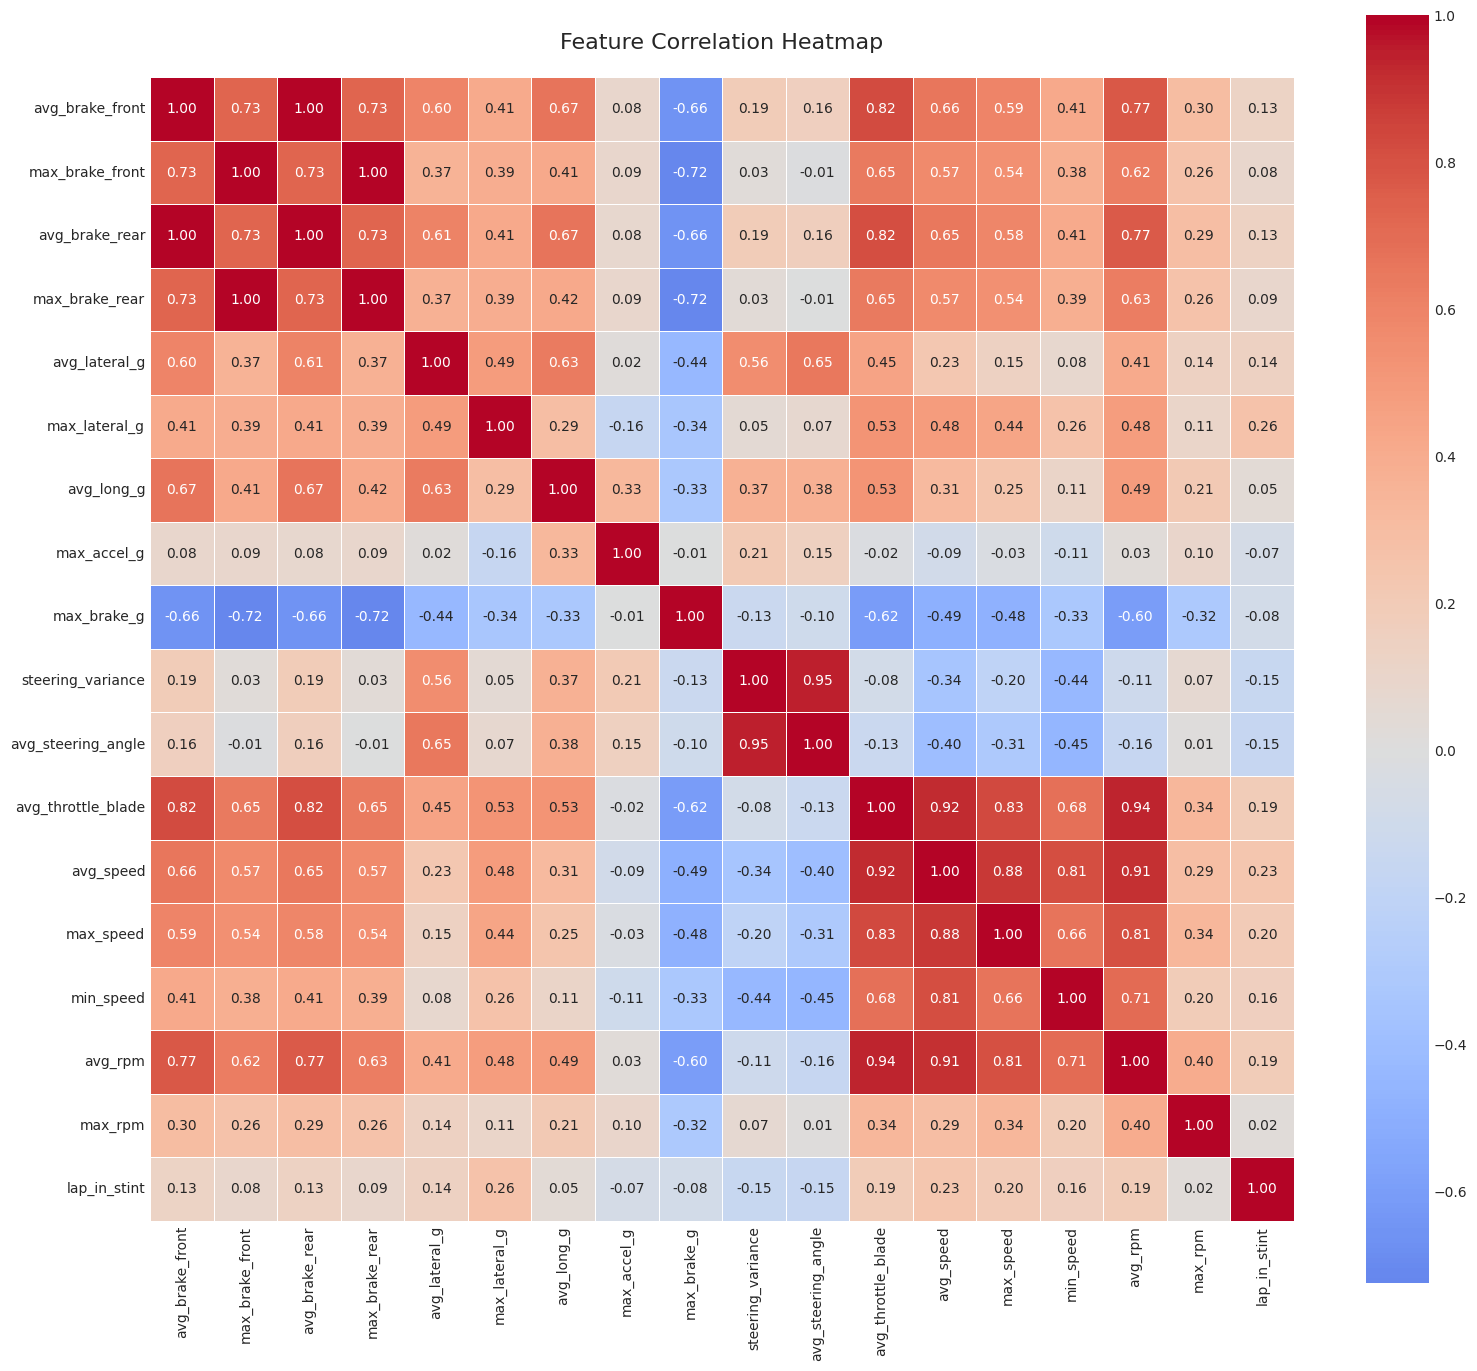


Highly correlated features (|r| > 0.9):
  avg_brake_rear <-> avg_brake_front: 0.997
  max_brake_rear <-> max_brake_front: 0.999
  avg_steering_angle <-> steering_variance: 0.948
  avg_speed <-> avg_throttle_blade: 0.925
  avg_rpm <-> avg_throttle_blade: 0.939
  avg_rpm <-> avg_speed: 0.910


In [5]:
# Feature correlation heatmap
plt.figure(figsize=(16, 14))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Identify highly correlated features (>0.9)
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            high_corr.append((correlation_matrix.columns[i], 
                            correlation_matrix.columns[j], 
                            correlation_matrix.iloc[i, j]))

if high_corr:
    print("\nHighly correlated features (|r| > 0.9):")
    for feat1, feat2, corr in high_corr:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")
else:
    print("\nNo highly correlated features found (threshold: |r| > 0.9)")

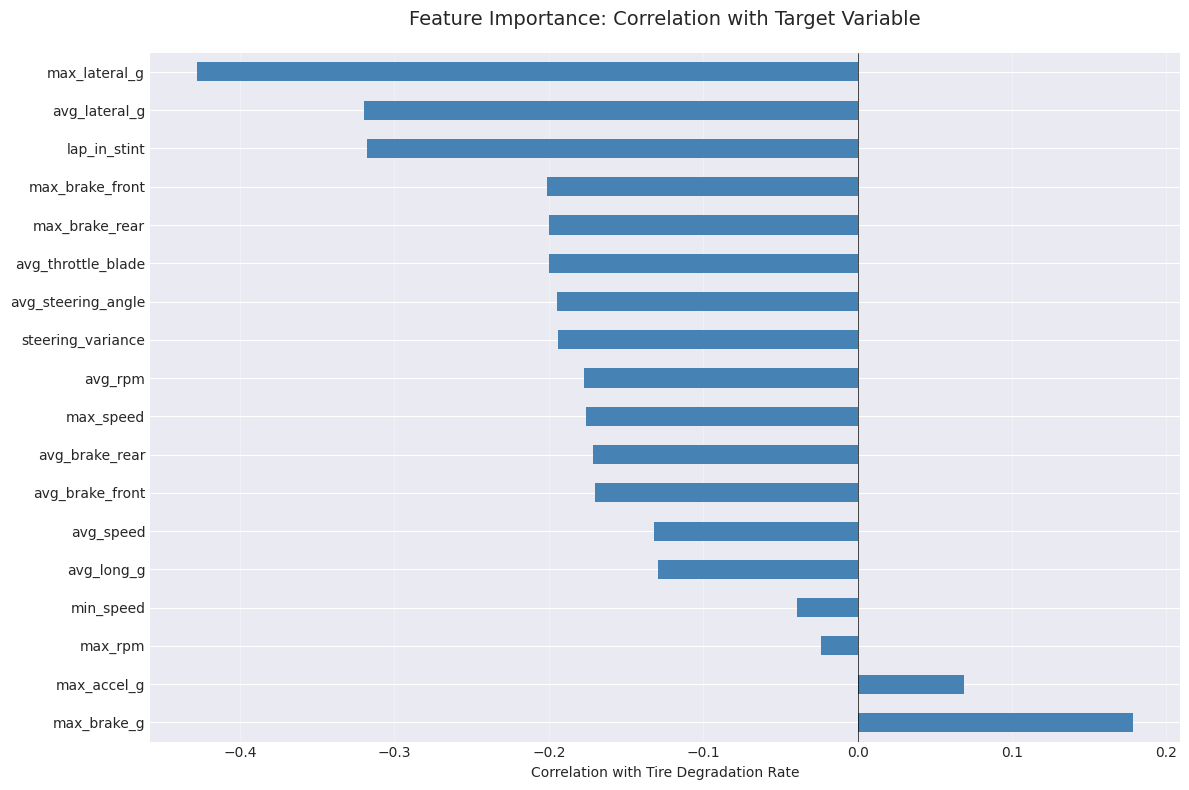


Top 5 positively correlated features:
max_brake_g    0.178462
max_accel_g    0.069175
max_rpm       -0.023963
min_speed     -0.039609
avg_long_g    -0.129332
dtype: float64

Top 5 negatively correlated features:
max_brake_rear    -0.200068
max_brake_front   -0.201129
lap_in_stint      -0.317597
avg_lateral_g     -0.319531
max_lateral_g     -0.427956
dtype: float64


In [6]:
# Feature vs Target correlation
feature_target_corr = X.corrwith(y).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
feature_target_corr.plot(kind='barh', color='steelblue')
plt.xlabel('Correlation with Tire Degradation Rate')
plt.title('Feature Importance: Correlation with Target Variable', fontsize=14, pad=20)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nTop 5 positively correlated features:")
print(feature_target_corr.head())
print("\nTop 5 negatively correlated features:")
print(feature_target_corr.tail())

## 4. Train/Test Split

In [7]:
# Split data (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train/Test ratio: {X_train.shape[0]/X_test.shape[0]:.2f}")

Training set: 2036 samples
Test set: 509 samples
Train/Test ratio: 4.00


## 5. Model Training and Evaluation

We'll train 6 different models and compare their performance.

In [8]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=0.01, random_state=42),
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ),
    'XGBoost': xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        device='cuda',  # XGBoost 3.x: use device='cuda' for GPU acceleration
        tree_method='hist',
        n_jobs=-1
    )
}

print("Models configured. Ready for training.")
print(f"\nNote: XGBoost configured with device='cuda' for GPU acceleration (XGBoost 3.x).")
print("If GPU is unavailable, it will automatically fall back to CPU.")

Models configured. Ready for training.

Note: XGBoost configured with device='cuda' for GPU acceleration (XGBoost 3.x).
If GPU is unavailable, it will automatically fall back to CPU.


In [9]:
# Train all models and collect results
results = {}
trained_models = {}

print("Training models...\n")
print("="*80)

for name, model in models.items():
    print(f"\n{name}:")
    print("-" * 40)
    
    # Train model
    start_time = datetime.now()
    model.fit(X_train, y_train)
    train_time = (datetime.now() - start_time).total_seconds()
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_ev = explained_variance_score(y_test, y_test_pred)
    
    # Cross-validation (5-fold)
    cv_scores = cross_val_score(
        model, X_train, y_train, cv=5, 
        scoring='r2', n_jobs=-1
    )
    
    # Store results
    results[name] = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_ev': test_ev,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'train_time': train_time,
        'predictions': y_test_pred
    }
    trained_models[name] = model
    
    # Print results
    print(f"Train R²:     {train_r2:.4f}")
    print(f"Test R²:      {test_r2:.4f}")
    print(f"Test MAE:     {test_mae:.4f}")
    print(f"Test RMSE:    {test_rmse:.4f}")
    print(f"Explained Var: {test_ev:.4f}")
    print(f"CV R² (5-fold): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"Training Time: {train_time:.2f}s")
    
    # Check for overfitting
    if train_r2 - test_r2 > 0.1:
        print("⚠️  Warning: Potential overfitting detected")

print("\n" + "="*80)
print("\nAll models trained successfully!")

Training models...


Linear Regression:
----------------------------------------
Train R²:     0.3311
Test R²:      0.2429
Test MAE:     0.5896
Test RMSE:    0.9086
Explained Var: 0.2477
CV R² (5-fold): 0.3098 ± 0.0659
Training Time: 0.00s

Ridge Regression:
----------------------------------------
Train R²:     0.3292
Test R²:      0.2464
Test MAE:     0.5862
Test RMSE:    0.9065
Explained Var: 0.2504
CV R² (5-fold): 0.3118 ± 0.0601
Training Time: 0.00s

Lasso Regression:
----------------------------------------
Train R²:     0.3109
Test R²:      0.2336
Test MAE:     0.5939
Test RMSE:    0.9141
Explained Var: 0.2367
CV R² (5-fold): 0.3022 ± 0.0530
Training Time: 0.00s

Random Forest:
----------------------------------------
Train R²:     0.8853
Test R²:      0.4928
Test MAE:     0.3889
Test RMSE:    0.7437
Explained Var: 0.4934
CV R² (5-fold): 0.4628 ± 0.0923
Training Time: 0.19s
⚠️  Warning: Potential overfitting detected

Gradient Boosting:
----------------------------------------
T

## 6. Model Comparison

In [10]:
# Create comparison dataframe
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df[['test_r2', 'test_mae', 'test_rmse', 'cv_mean', 'cv_std', 'train_time']]
comparison_df = comparison_df.sort_values('test_r2', ascending=False)

print("\nModel Performance Comparison:")
print("="*100)
print(comparison_df.to_string())
print("\n" + "="*100)

best_model_name = comparison_df.index[0]
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test R²: {comparison_df.loc[best_model_name, 'test_r2']:.4f}")
print(f"   Test MAE: {comparison_df.loc[best_model_name, 'test_mae']:.4f}")
print(f"   Test RMSE: {comparison_df.loc[best_model_name, 'test_rmse']:.4f}")


Model Performance Comparison:
                    test_r2  test_mae test_rmse   cv_mean    cv_std train_time
Random Forest      0.492777  0.388909  0.743702  0.462796  0.092327   0.186406
XGBoost            0.473837  0.420133  0.757461  0.467252  0.078426   0.605105
Gradient Boosting  0.463765  0.416711  0.764676  0.438399  0.095469   1.248075
Ridge Regression   0.246379  0.586237  0.906518  0.311787    0.0601   0.001897
Linear Regression  0.242903  0.589556  0.908606  0.309768  0.065892   0.001987
Lasso Regression   0.233645  0.593907  0.914144  0.302188     0.053   0.002801


🏆 Best Model: Random Forest
   Test R²: 0.4928
   Test MAE: 0.3889
   Test RMSE: 0.7437


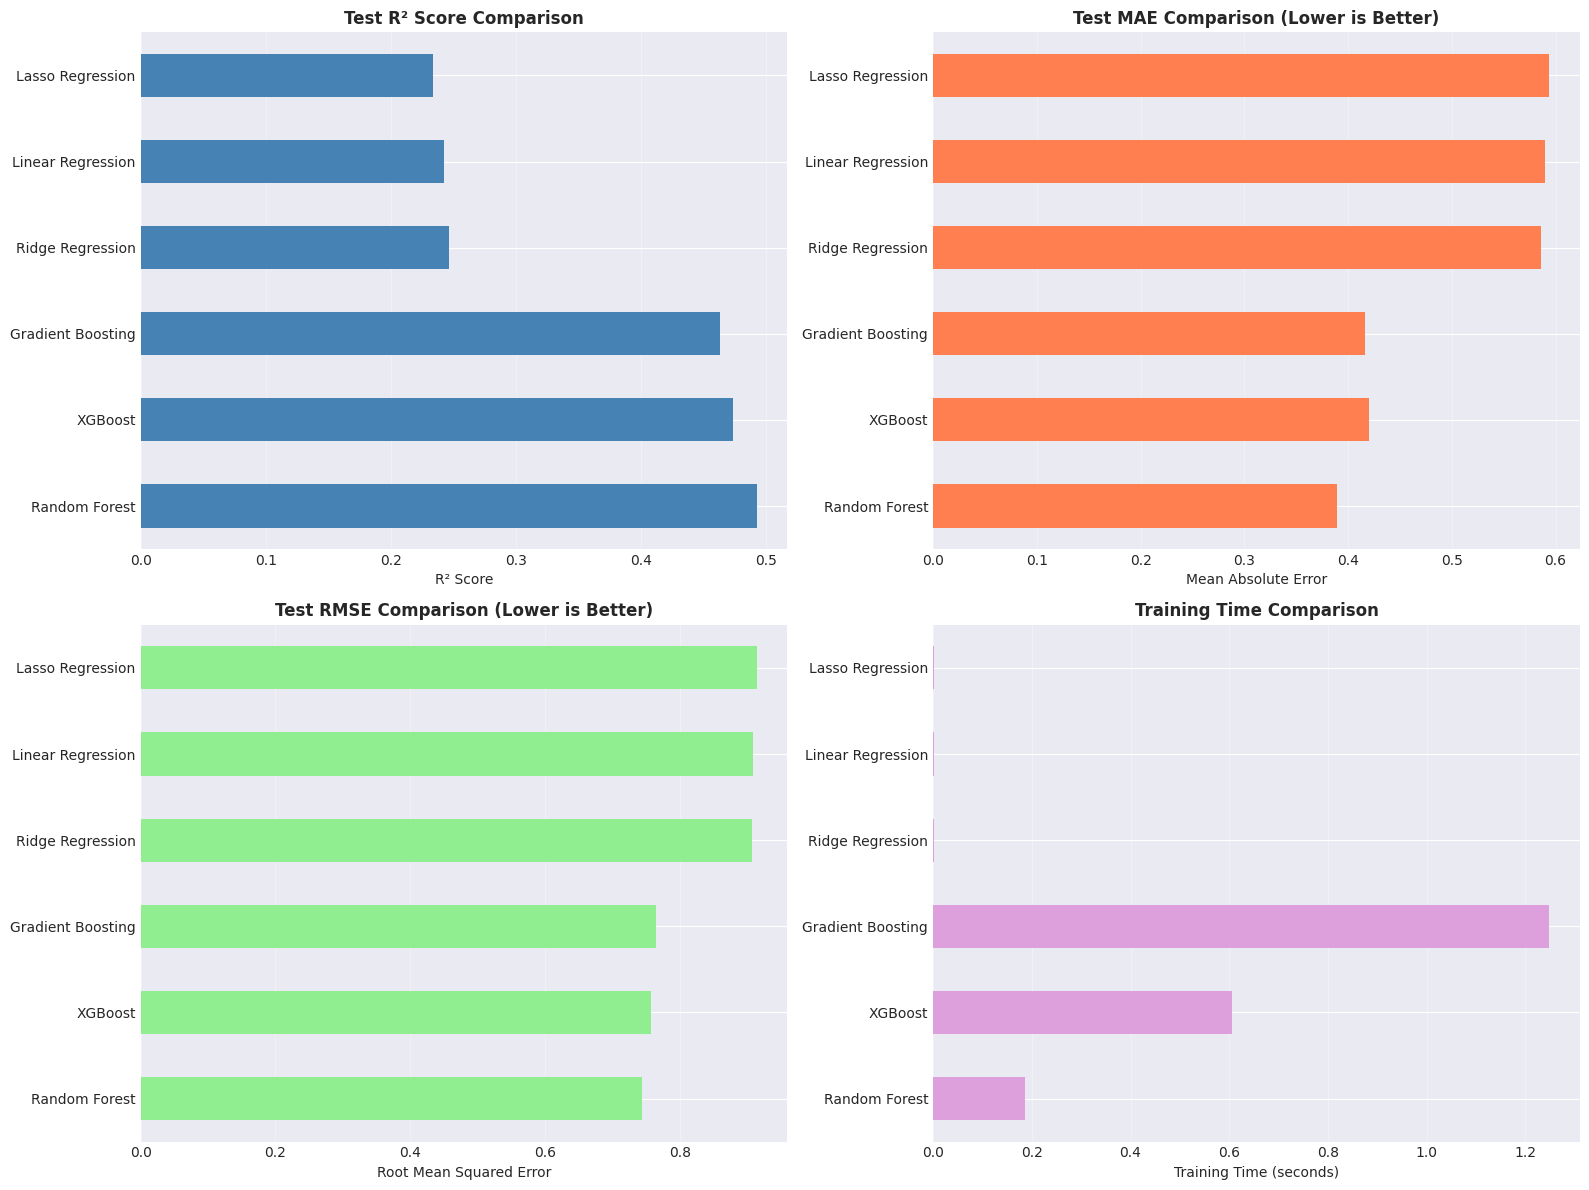

In [11]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# R² Score
comparison_df['test_r2'].plot(kind='barh', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_xlabel('R² Score')
axes[0, 0].set_title('Test R² Score Comparison', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# MAE
comparison_df['test_mae'].plot(kind='barh', ax=axes[0, 1], color='coral')
axes[0, 1].set_xlabel('Mean Absolute Error')
axes[0, 1].set_title('Test MAE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# RMSE
comparison_df['test_rmse'].plot(kind='barh', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_xlabel('Root Mean Squared Error')
axes[1, 0].set_title('Test RMSE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Training Time
comparison_df['train_time'].plot(kind='barh', ax=axes[1, 1], color='plum')
axes[1, 1].set_xlabel('Training Time (seconds)')
axes[1, 1].set_title('Training Time Comparison', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 7. Predictions vs Actual (Best Model)

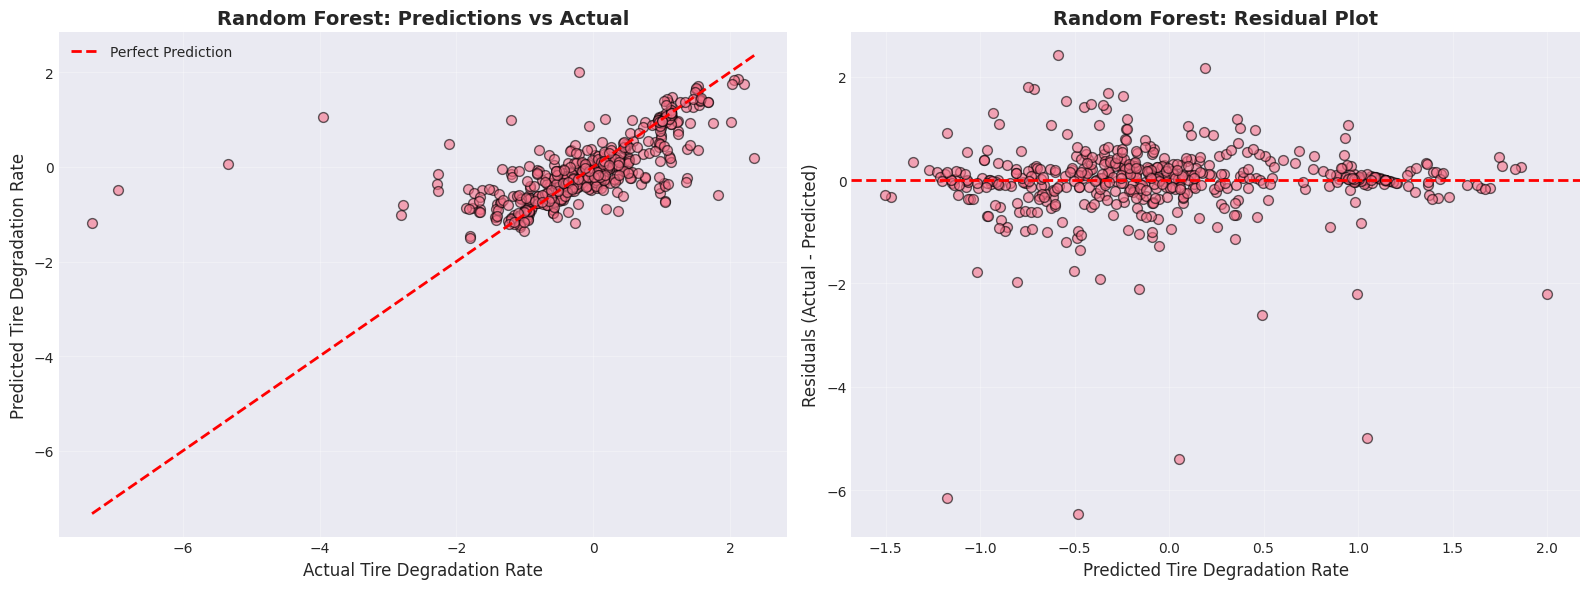


Residual Statistics (Random Forest):
Mean: -0.025575
Std Dev: 0.743994
Min: -6.455379
Max: 2.414642


In [12]:
# Get best model predictions
best_predictions = results[best_model_name]['predictions']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot: Predicted vs Actual
axes[0].scatter(y_test, best_predictions, alpha=0.6, edgecolor='black', s=50)
axes[0].plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Tire Degradation Rate', fontsize=12)
axes[0].set_ylabel('Predicted Tire Degradation Rate', fontsize=12)
axes[0].set_title(f'{best_model_name}: Predictions vs Actual', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = y_test - best_predictions
axes[1].scatter(best_predictions, residuals, alpha=0.6, edgecolor='black', s=50)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Tire Degradation Rate', fontsize=12)
axes[1].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
axes[1].set_title(f'{best_model_name}: Residual Plot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residual statistics
print(f"\nResidual Statistics ({best_model_name}):")
print(f"Mean: {residuals.mean():.6f}")
print(f"Std Dev: {residuals.std():.6f}")
print(f"Min: {residuals.min():.6f}")
print(f"Max: {residuals.max():.6f}")

## 8. Feature Importance Analysis

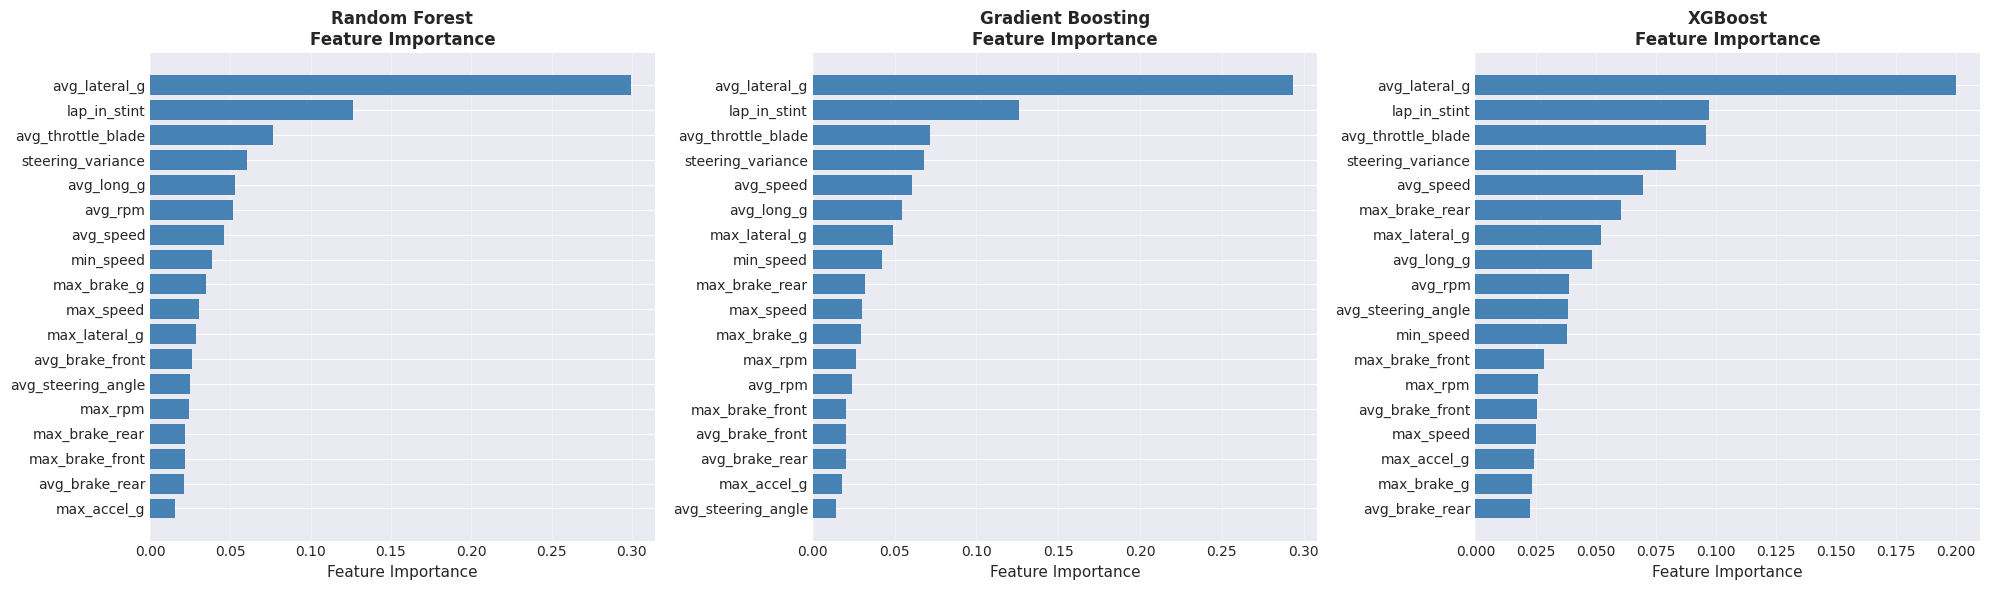


Top 10 Most Important Features (Random Forest):
           feature  importance
     avg_lateral_g    0.299238
      lap_in_stint    0.126452
avg_throttle_blade    0.076284
 steering_variance    0.060547
        avg_long_g    0.052589
           avg_rpm    0.051457
         avg_speed    0.045965
         min_speed    0.038812
       max_brake_g    0.034657
         max_speed    0.030496


In [13]:
# Feature importance for tree-based models
tree_models = ['Random Forest', 'Gradient Boosting', 'XGBoost']

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, model_name in enumerate(tree_models):
    if model_name in trained_models:
        model = trained_models[model_name]
        
        # Get feature importance
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
            feature_importance_df = pd.DataFrame({
                'feature': X.columns,
                'importance': importance
            }).sort_values('importance', ascending=True)
            
            # Plot
            axes[idx].barh(feature_importance_df['feature'], 
                          feature_importance_df['importance'],
                          color='steelblue')
            axes[idx].set_xlabel('Feature Importance', fontsize=11)
            axes[idx].set_title(f'{model_name}\nFeature Importance', 
                               fontsize=12, fontweight='bold')
            axes[idx].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Print top 10 features for best model (if tree-based)
if best_model_name in tree_models:
    best_model = trained_models[best_model_name]
    feature_importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 10 Most Important Features ({best_model_name}):")
    print("="*60)
    print(feature_importance_df.head(10).to_string(index=False))

## 9. Save Best Model

In [14]:
# Create models directory if it doesn't exist
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

# Save best model
best_model = trained_models[best_model_name]
model_filename = f'tire_degradation_model_{best_model_name.lower().replace(" ", "_")}.pkl'
model_path = models_dir / model_filename

joblib.dump(best_model, model_path)
print(f"✅ Best model saved: {model_path}")

# Save all models
print("\nSaving all trained models...")
for name, model in trained_models.items():
    filename = f'tire_degradation_model_{name.lower().replace(" ", "_")}.pkl'
    filepath = models_dir / filename
    joblib.dump(model, filepath)
    print(f"  ✅ {name} -> {filepath.name}")

# Save model metadata
metadata = {
    'best_model': best_model_name,
    'best_test_r2': results[best_model_name]['test_r2'],
    'best_test_mae': results[best_model_name]['test_mae'],
    'best_test_rmse': results[best_model_name]['test_rmse'],
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'training_samples': X_train.shape[0],
    'test_samples': X_test.shape[0],
    'features': list(X.columns),
    'all_models': {name: {
        'test_r2': results[name]['test_r2'],
        'test_mae': results[name]['test_mae'],
        'test_rmse': results[name]['test_rmse'],
        'cv_mean': results[name]['cv_mean'],
        'cv_std': results[name]['cv_std']
    } for name in results.keys()}
}

import json
metadata_path = models_dir / 'model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\n✅ Model metadata saved: {metadata_path}")

✅ Best model saved: ../models/tire_degradation_model_random_forest.pkl

Saving all trained models...
  ✅ Linear Regression -> tire_degradation_model_linear_regression.pkl
  ✅ Ridge Regression -> tire_degradation_model_ridge_regression.pkl
  ✅ Lasso Regression -> tire_degradation_model_lasso_regression.pkl
  ✅ Random Forest -> tire_degradation_model_random_forest.pkl
  ✅ Gradient Boosting -> tire_degradation_model_gradient_boosting.pkl
  ✅ XGBoost -> tire_degradation_model_xgboost.pkl

✅ Model metadata saved: ../models/model_metadata.json


## 10. Model Loading Example (For Future Use)

In [15]:
# Example: Load trained model
loaded_model = joblib.load(model_path)
print(f"✅ Model loaded from: {model_path}")

# Test prediction on first 5 test samples
sample_predictions = loaded_model.predict(X_test.head())
print(f"\nSample predictions (first 5 test samples):")
for i, (actual, pred) in enumerate(zip(y_test.head(), sample_predictions)):
    print(f"  Sample {i+1}: Actual={actual:.4f}, Predicted={pred:.4f}, Error={abs(actual-pred):.4f}")

✅ Model loaded from: ../models/tire_degradation_model_random_forest.pkl

Sample predictions (first 5 test samples):
  Sample 1: Actual=-0.3366, Predicted=-0.3670, Error=0.0304
  Sample 2: Actual=-0.3261, Predicted=0.3522, Error=0.6783
  Sample 3: Actual=1.0106, Predicted=1.0152, Error=0.0046
  Sample 4: Actual=0.5093, Predicted=0.2122, Error=0.2971
  Sample 5: Actual=0.7010, Predicted=-0.3688, Error=1.0697


print("\n" + "="*80)
print("TRAINING COMPLETE - SUMMARY")
print("="*80)

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test R²: {results[best_model_name]['test_r2']:.4f}")
print(f"   Test MAE: {results[best_model_name]['test_mae']:.4f} seconds/lap")
print(f"   Test RMSE: {results[best_model_name]['test_rmse']:.4f} seconds/lap")
print(f"   CV R² (5-fold): {results[best_model_name]['cv_mean']:.4f} ± {results[best_model_name]['cv_std']:.4f}")

print(f"\n📊 Models Trained: {len(trained_models)}")
print(f"📁 Models Saved: {len(list(models_dir.glob('*.pkl')))}")
print(f"📈 Training Samples: {X_train.shape[0]}")
print(f"📉 Test Samples: {X_test.shape[0]}")
print(f"🔧 Features Used: {X.shape[1]}")

print("\n" + "="*80)
print("DATA NOTES:")
print("="*80)
print("""
⚠️  Throttle Features:
- 3 features removed (avg/max_throttle_pos, throttle_variance)
- These are NULL because dataset has 2 different throttle sensors:
  * Races 1-8: Use 'ath' (throttle blade) - in current dataset ✅
  * Races 9-10: Use 'aps' (throttle position) - not in current dataset
- Using only 'avg_throttle_blade' which is available for all laps

✅ GPU Configuration:
- XGBoost 3.x uses device='cuda' (not tree_method='gpu_hist')
- GPU: NVIDIA RTX 3080 with CUDA 12.8
- Set device='cuda' in XGBoost model configuration
""")

print("\n" + "="*80)
print("NEXT STEPS:")
print("="*80)
print("""
1. 🔧 Hyperparameter Tuning:
   - Use GridSearchCV/RandomizedSearchCV on top 3 models
   - Focus on: n_estimators, max_depth, learning_rate, min_samples_split
   - Leverage GPU for faster XGBoost tuning
   
2. 🔬 Feature Engineering:
   - Create interaction features (e.g., brake_pressure * lateral_g)
   - Add polynomial features for non-linear relationships
   - Test lap_in_stint transformations (log, sqrt)
   - Consider track-specific features
   
3. 🎯 Model Ensembling:
   - Stack top 3 models (Random Forest, XGBoost, Gradient Boosting)
   - Use VotingRegressor or Stacking with meta-learner
   - Weighted averaging based on CV scores
   
4. 📊 Additional Data:
   - Consider adding races 9-10 (Indianapolis, Barber) with 'aps' sensor
   - Would add ~1,057 laps to dataset (~31% increase)
   - Use COALESCE(aps, ath) in SQL view to combine both sensors
   
5. 🚀 Production Pipeline:
   - Convert notebook to src/train_model.py
   - Add command-line arguments for hyperparameters
   - Create src/predict.py for inference on new data
   - Add model versioning and experiment tracking
   
6. 📝 Documentation:
   - Document model performance and limitations
   - Create model card with feature descriptions
   - Add training guide to README.md
""")
print("="*80)

In [16]:
print("\n" + "="*80)
print("TRAINING COMPLETE - SUMMARY")
print("="*80)

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test R²: {results[best_model_name]['test_r2']:.4f}")
print(f"   Test MAE: {results[best_model_name]['test_mae']:.4f} seconds/lap")
print(f"   Test RMSE: {results[best_model_name]['test_rmse']:.4f} seconds/lap")
print(f"   CV R² (5-fold): {results[best_model_name]['cv_mean']:.4f} ± {results[best_model_name]['cv_std']:.4f}")

print(f"\n📊 Models Trained: {len(trained_models)}")
print(f"📁 Models Saved: {len(list(models_dir.glob('*.pkl')))}")
print(f"📈 Training Samples: {X_train.shape[0]}")
print(f"📉 Test Samples: {X_test.shape[0]}")

print("\n" + "="*80)
print("NEXT STEPS:")
print("="*80)
print("""
1. 🖥️  Transfer to Windows for GPU training:
   - Follow database transfer instructions in docs/DATABASE_TRANSFER.md
   - Install GPU requirements: pip install -r requirements-gpu.txt
   - Update XGBoost tree_method to 'gpu_hist' for CUDA acceleration
   
2. 🔧 Hyperparameter Tuning:
   - Use GridSearchCV/RandomizedSearchCV on best models
   - Focus on: n_estimators, max_depth, learning_rate, min_samples_split
   
3. 🔬 Feature Engineering:
   - Create interaction features (e.g., brake_pressure * lateral_g)
   - Add polynomial features
   - Test lap_in_stint transformations (log, sqrt)
   
4. 🎯 Model Ensembling:
   - Stack top 3 models (VotingRegressor)
   - Weighted averaging based on CV scores
   
5. 🚀 Production Script:
   - Convert this notebook to src/train_model.py
   - Add command-line arguments
   - Create src/predict.py for inference
   
6. 📝 Documentation:
   - Document model performance in README.md
   - Create model card with metrics and limitations
""")
print("="*80)


TRAINING COMPLETE - SUMMARY

🏆 Best Model: Random Forest
   Test R²: 0.4928
   Test MAE: 0.3889 seconds/lap
   Test RMSE: 0.7437 seconds/lap
   CV R² (5-fold): 0.4628 ± 0.0923

📊 Models Trained: 6
📁 Models Saved: 6
📈 Training Samples: 2036
📉 Test Samples: 509

NEXT STEPS:

1. 🖥️  Transfer to Windows for GPU training:
   - Follow database transfer instructions in docs/DATABASE_TRANSFER.md
   - Install GPU requirements: pip install -r requirements-gpu.txt
   - Update XGBoost tree_method to 'gpu_hist' for CUDA acceleration

2. 🔧 Hyperparameter Tuning:
   - Use GridSearchCV/RandomizedSearchCV on best models
   - Focus on: n_estimators, max_depth, learning_rate, min_samples_split

3. 🔬 Feature Engineering:
   - Create interaction features (e.g., brake_pressure * lateral_g)
   - Add polynomial features
   - Test lap_in_stint transformations (log, sqrt)

4. 🎯 Model Ensembling:
   - Stack top 3 models (VotingRegressor)
   - Weighted averaging based on CV scores

5. 🚀 Production Script:
   - C